# Genetic optimization of Gradient Boosting classifier for the SDSS data

## Load data

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [2]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {
    "loss": ["deviance", "exponential"],
    "learning_rate": np.logspace(-2, 1, num=20, base=10),
    "n_estimators": np.logspace(1, 3.5, num=20, base=10, dtype=int),
    "criterion": ["friedman_mse"],
    "min_samples_split": np.arange(2, 10),
    "min_samples_leaf": np.arange(1, 10),
    "max_depth": np.arange(3, 9),
    "random_state": [42],
}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=GradientBoostingClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=3,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=15,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X_train, y_train)

Types [1, 2, 1, 1, 1, 1, 1, 1] and maxint [1, 19, 19, 0, 7, 8, 5, 0] detected
[CV] loss=deviance, learning_rate=6.951927961775605, n_estimators=18, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=8, max_depth=6, random_state=42 
[CV] loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=1, max_depth=3, random_state=42 
[CV] loss=exponential, learning_rate=4.832930238571752, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=4, max_depth=6, random_state=42 
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=61, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=8, max_depth=7, random_state=42 
[CV] loss=exponential, learning_rate=1.623776739188721, n_estimators=3162, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=33, criterio

[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=61, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=8, max_depth=7, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=1.623776739188721, n_estimators=3162, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=1, max_depth=3, random_state=42, score=0.0, total=   0.0s
[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=33, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=1, max_depth=6, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=33, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=1, max_depth=6, random_state=42 
[CV]  loss=exponential, learning_rate=1.623776739188721, n_estimators=3162, cr

[CV] loss=deviance, learning_rate=3.359818286283781, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=9, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.7847599703514611, n_estimators=61, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=9, max_depth=4, random_state=42, score=0.9933333333333333, total=   1.2s
[CV] loss=deviance, learning_rate=0.7847599703514611, n_estimators=61, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=9, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=4.832930238571752, n_estimators=112, criterion=fried

[CV] loss=exponential, learning_rate=0.01, n_estimators=83, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=3, max_depth=3, random_state=42 
[CV]  loss=exponential, learning_rate=0.01, n_estimators=83, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=3, max_depth=3, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=513, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=4, max_depth=7, random_state=42 
[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=513, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=4, max_depth=7, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=513, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=4, max_depth=7, random_state=42 
[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=513, criterion=friedman_mse, min_samples_split=9, min_samples

[CV] loss=exponential, learning_rate=0.06158482110660264, n_estimators=3162, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=4, max_depth=5, random_state=42 
[CV]  loss=exponential, learning_rate=0.06158482110660264, n_estimators=3162, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=4, max_depth=5, random_state=42, score=0.0, total=   0.0s
[CV] loss=deviance, learning_rate=6.951927961775605, n_estimators=513, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=2, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=18, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=5, max_depth=8, random_state=42, score=0.9900066622251832, total=   0.9s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=18, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=5, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=2.3357214690901213, n_estimators=83, criterion=friedma

[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=280, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=8, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=280, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.0206913808111479, n_estimators=33, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=9, max_depth=4, random_state=42, score=0.9893262174783188, total=   0.7s
[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=280, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=8, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=280, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=8, random_state=42 
[CV] loss=exponential, learning_rate=10.0, n_estimators=1274, cri

[CV]  loss=deviance, learning_rate=1.1288378916846884, n_estimators=18, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886666666666667, total=   0.4s
[CV] loss=deviance, learning_rate=1.1288378916846884, n_estimators=18, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=1.623776739188721, n_estimators=112, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=3, random_state=42, score=0.9880079946702198, total=   1.3s
[CV] loss=deviance, learning_rate=1.623776739188721, n_estimators=112, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=1.1288378916846884, n_estimators=18, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9613075383589059, total=   0.4s
[CV] loss=deviance, learning_rate=1.12883789168

[CV] loss=exponential, learning_rate=0.7847599703514611, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=2, max_depth=5, random_state=42 
[CV] loss=deviance, learning_rate=0.37926901907322497, n_estimators=13, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=8, random_state=42 
[CV]  loss=exponential, learning_rate=0.7847599703514611, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=2, max_depth=5, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.7847599703514611, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=2, max_depth=5, random_state=42 
[CV]  loss=exponential, learning_rate=0.7847599703514611, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=2, max_depth=5, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.7847599703514611, n_estimators=206, criterion=friedman_mse, mi

[CV] loss=deviance, learning_rate=6.951927961775605, n_estimators=206, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=5, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9859906604402935, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9933288859239493, total=   1.5s
[CV] loss=deviance, learning_rate=0.37926901907322497, n_estimators=2335, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=6, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=6.951927961775605, n_estimators=206, criterion=

[CV]  loss=deviance, learning_rate=0.7847599703514611, n_estimators=1725, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=9, max_depth=4, random_state=42, score=0.9813457694870087, total=  25.4s
[CV] loss=deviance, learning_rate=0.7847599703514611, n_estimators=1725, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=9, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=1.1288378916846884, n_estimators=1725, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=5, max_depth=3, random_state=42, score=0.8514323784143905, total=  30.7s
[CV] loss=deviance, learning_rate=1.1288378916846884, n_estimators=1725, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=5, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=3.359818286283781, n_estimators=206, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=4, random_state=42, score=0.8912608405603736, total=   3.2s
[CV] loss=deviance, learning_rate=3.359

[CV]  loss=deviance, learning_rate=0.7847599703514611, n_estimators=1725, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=9, max_depth=4, random_state=42, score=0.9933333333333333, total=   6.5s
[CV] loss=deviance, learning_rate=0.7847599703514611, n_estimators=1725, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=9, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=6.951927961775605, n_estimators=513, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=2, max_depth=8, random_state=42, score=0.5637091394262842, total=  20.5s
[CV] loss=exponential, learning_rate=3.359818286283781, n_estimators=941, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=5, random_state=42 
[CV]  loss=exponential, learning_rate=3.359818286283781, n_estimators=941, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=5, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=3.3598182862837

[CV] loss=exponential, learning_rate=0.01, n_estimators=941, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=7, max_depth=8, random_state=42 
[CV]  loss=exponential, learning_rate=0.01, n_estimators=941, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=7, max_depth=8, random_state=42, score=0.0, total=   0.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42 
[CV] loss=deviance, learning_rate=1.1288378916846884, n_estimators=24, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=4, max_depth=7, random_stat

[CV] loss=deviance, learning_rate=0.06158482110660264, n_estimators=45, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42, score=0.9880079946702198, total=   3.3s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.37926901907322497, n_estimators=13, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=8, random_state=42, score=0.9893404397068621, total=   0.7s
[CV] loss=deviance, learning_rate=0.37926901907322497, n_estimators=13, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterio

[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.8s
[CV] loss=deviance, learning_rate=3.359818286283781, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=9, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9880079946702198, total=   0.2s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=fr

[CV] loss=exponential, learning_rate=0.08858667904100823, n_estimators=379, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=exponential, learning_rate=0.08858667904100823, n_estimators=379, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=4, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.08858667904100823, n_estimators=379, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=exponential, learning_rate=0.08858667904100823, n_estimators=379, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=4, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.08858667904100823, n_estimators=379, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=exponential, learning_rate=0.08858667904100823, n_estimators=379, criterion=friedm

[CV]  loss=deviance, learning_rate=1.1288378916846884, n_estimators=18, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9826551034022681, total=   0.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=7, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=3.359818286283781, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=9, max_depth=5, random_state=42, score=0.29580279813457694, total=   2.5s
[CV] loss=deviance, learning_rate=3.359818286283781, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=9, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9880079946702198, total=   1.5s
[CV] loss=deviance, learning_rate=0.263665089

[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=6, max_depth=4, random_state=42, score=0.9946666666666667, total=   9.5s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=6, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=3.359818286283781, n_estimators=513, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=7, max_depth=7, random_state=42, score=0.766, total=   9.7s
[CV] loss=deviance, learning_rate=3.359818286283781, n_estimators=513, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=7, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=6, max_depth=4, random_state=42, score=0.9866577718478986, total=   9.3s
[CV] loss=deviance, learning_rate=0.263665089873035

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=4, random_state=42, score=0.9873417721518988, total=   1.2s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterio

[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=2, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=2, max_depth=4, random_state=42, score=0.9860093271152565, total=   0.4s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=2, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9926617745163442, total=   1.4s
[CV] loss=deviance, learning_rate=0.12742749857031335, n_estimators=10, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.029763514416313176, n_estimators=61, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9860093271152565, total=   1.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9880079946702198, total=   1.5s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion

[CV] loss=deviance, learning_rate=0.37926901907322497, n_estimators=13, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=5, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.029763514416313176, n_estimators=61, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=8, random_state=42, score=0.994, total=   2.3s
[CV] loss=deviance, learning_rate=0.029763514416313176, n_estimators=61, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9926617745163442, total=   1.5s
[CV] loss=deviance, learning_rate=0.12742749857031335, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=61, criterion=friedman_m

[CV] loss=deviance, learning_rate=0.08858667904100823, n_estimators=695, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=2, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.12742749857031335, n_estimators=10, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=2, max_depth=5, random_state=42, score=0.9866577718478986, total=   0.3s
[CV] loss=deviance, learning_rate=0.12742749857031335, n_estimators=10, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=2, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.12742749857031335, n_estimators=10, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=2, max_depth=5, random_state=42, score=0.9919946631087392, total=   0.3s
[CV] loss=deviance, learning_rate=0.12742749857031335, n_estimators=18, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.12742749857031335, n_estimators=18, criterion

[CV] loss=deviance, learning_rate=0.12742749857031335, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42, score=0.9926617745163442, total=   3.3s
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=695, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=2, max_depth=5, random_state=42, score=0.9953333333333333, total=   6.7s
[CV] loss=deviance, learning_rate=0.08858667904100823, n_estimators=695, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=2, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.12742749857031335, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=8, random_state=42, score=0.9873248832555037, total=   3.5s
[CV] loss=deviance, learning_rate=0.1

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42, score=0.9880079946702198, total=   3.4s
[CV] loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterio

[CV] loss=deviance, learning_rate=0.37926901907322497, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterio

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=7, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=3, random_state=42, score=0.9886591060707138, total=   2.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=7, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9953333333333333, total=   3.9s
[CV] loss=deviance, learning_rate=0.08858667904100823, n_estimators=206, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.12742749857031335, n_estimators=206, cri

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9933333333333333, total=   0.2s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9879919946631087, total=   0.3s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterio

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=4, random_state=42, score=0.9900066622251832, total=   1.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9900066622251832, total=  10.3s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criter

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=7, max_depth=3, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=695, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9879919946631087, total=   4.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=695, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=2335, criterion=friedman

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=2335, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9879919946631087, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=7, max_depth=5, random_state=42, score=0.9893404397068621, total=   2.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=7, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.08858667904100823, n_estimators=3162, cr

3  	33    	0.990672	0.989867	0.990933	0.000299285
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9900066622251832, total=   0.3s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9900066622251832, total=   0.3s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=13, criterion=friedman_mse, min_samples_split=9, min_samples_leaf=5, max_depth=4, random_state=42, score=0.9880079946702198, total=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=45, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893262174783188, total=   1.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=45, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9866755496335776, total=   1.4s
[CV] loss=deviance, learning_rate=0.263665

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9926617745163442, total=   1.6s
[CV] loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, crit

[CV]  loss=deviance, learning_rate=0.37926901907322497, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9906666666666667, total=   1.1s
[CV] loss=deviance, learning_rate=0.37926901907322497, n_estimators=61, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   2.2s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   2.0s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9879919946631087, total=   1.6s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
4  	38    	0.951184	0       	0.990933	0.19416    
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, cr

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.8s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=9, max_depth=5, random_state=42, score=0.9866577718478986, total=   1.8s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=45, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9939959973315544, total=   1.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.8s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=3162, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=3162, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9879919946631087, total=  12.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=3162, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=3162, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=  12.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, cr

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   2.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=695, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9900066622251832, total=   4.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=695, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterio

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.0s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   2.3s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, 

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   2.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   2.3s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.2s
[CV]  loss=deviance, learning_rate=0.18329807108324356,

[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42, score=0.9873417721518988, total=   1.4s
[CV] loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   3.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=7, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.26366508987303583, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42, score=0.9926617745163442, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.7s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=24, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   0.8s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.7s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   2.1s
[CV]  loss=deviance, learning_rate=3.359818286283781, n

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.1s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   2.0s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9886591060707138, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=5, max_depth=7, random_state=42, score=0.9866755496335776, total=   2.2s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=5, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.2s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse,

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.8s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   6.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   6.4s
[CV] loss=deviance, learning_rate=0.18329807108

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.996, total=   1.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9873417721518988, total=   2.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   2.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, 

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   3.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   2.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42, score=0.9900066622251832, total=   1.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42, score=0.9953333333333333, total=   1.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=4, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=5, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9893404397068621, total=   1.7s
[CV] loss=deviance, learning_rate=0.183298

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=5, random_state=42, score=0.9933288859239493, total=   1.6s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=exponential, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=exponential, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=exponential, learning_rate=0.18329807108324356, n_estimators=1274, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.18329807108324356, n_es

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   2.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=8, random_state=42, score=0.9893404397068621, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse,

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=8, random_state=42, score=0.9893262174783188, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse,

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=7, max_depth=7, random_state=42, score=0.9926617745163442, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=2, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

10 	39    	0.971344	0       	0.9912  	0.138763   
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=10, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.988674217188541, total=   0.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=10, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=10, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9880079946702198, total=   0.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=10, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=10.0, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.5329780146568954, total=   1.2s
[CV] los

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=2, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=10.0, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_sa

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, 

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.2s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=8, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=2, max_depth=7, random_state=42 
[CV]  loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=2, max_depth=7, random_state=42, score=0.0, total=   0.0s
[CV] loss=exponential, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_l

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   3.1s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=513, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   3.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=513, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterio

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.1s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.7s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.0s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.0s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.0s
[CV]  loss=deviance, learning_rate=0.18329

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   3.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.5s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, 

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.9s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.7s
[CV] loss=deviance, learning_rate=0.183298

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=513, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   3.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=513, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9873417721518988, total=   1.8s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterio

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=513, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   3.4s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42 
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_sa

[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.2s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion

[CV] loss=deviance, learning_rate=0.029763514416313176, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.2s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=4, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=2, max_depth=8, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   3.2s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.996, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9900066622251832, total=   2.1s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.029763514416313176, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9919946631087392, total=   2.6s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=206, criterio

[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.0s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=6, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9939959973315544, total=   2.1s
[CV]  loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42, score=0.9886591060707138, total=   2.0s
[CV] loss=deviance, learning_rate=0.18329807108324356, n_estimators=83, criterion=friedman_mse, min_samples_split=3, min_samples_leaf=3, max_depth=7, random_state=42 
[CV]  loss=deviance, learning_rate=0.18329

Data Set Type:  Standard Scaled
GradientBoostingClassifier
[0.99000666 0.98800799 0.99666667 0.98599066 0.99266177]
Accuracy: 0.991 (+/- 0.007)
GradientBoostingClassifier :
 [[1233    6    7]
 [  13  229    0]
 [   2    0 1010]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
GradientBoostingClassifier 0.9906667517037414


By Precision(avg=micro):
GradientBoostingClassifier 0.9888


By Recall(avg=micro):
GradientBoostingClassifier 0.9888


By F1(avg=micro):
GradientBoostingClassifier 0.9888


By Precision(avg=macro):
GradientBoostingClassifier 0.9851886217177594


By Recall(avg=macro):
GradientBoostingClassifier 0.977957106770892


By F1(avg=macro):

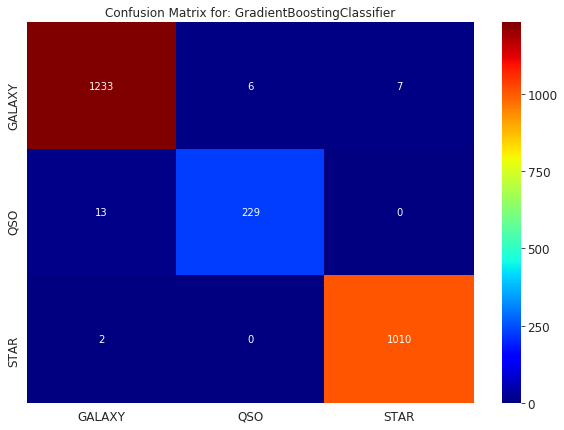

In [5]:
best_indiv = GradientBoostingClassifier(loss="deviance",
                                        learning_rate=0.18329807108324356, 
                                        n_estimators=83,
                                        criterion="friedman_mse",
                                        min_samples_split=3,
                                        min_samples_leaf=7, 
                                        max_depth=7, 
                                        random_state=42)

clf_names = ["GradientBoostingClassifier"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs = [best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)